# Tarea - Modelo ARIMA

Sofía Maldonado García 

11/02/2026

### 1) Utilizando como base la forma canónica de un modelo ARIMA (p,d,q) desarrollar el caso en el que se considera un modelo de orden ARIMA(2,1,2)
- Realizar el procedimiento y detalle de sus conclusiones/pasos.

Considerando la forma canónica:
$$
\phi_{p}(B)(1-B)^dY_{t}=c+\theta_{q}(B)\epsilon_{t}
$$
Donde:
$$
\phi_{p}(B)=1-\phi_{1}B-\phi_{2}B^2-\dots-\phi_{p}B^p 
$$
Y:
$$
\theta_{q}(B)= 1 + \theta_{1}B+\theta_{2}B^2+\dots+\theta_{q}B^q
$$
Un modelo ARIMA con orden (2,1,2) sería representado como:
$$
(1-\phi_{1}B-\phi_{2}B^2)(1-B)Y_{t}=c+(1+\theta_{1}B+\theta_{2}B^2)\epsilon_{t}
$$
Desarrollando...
$$
(1-\phi_{1}B-\phi_{2}B^2-B+\phi_{1}B^2+\phi_{2}B^3)Y_{t}=c+(1+\theta_{1}B+\theta_{2}B^2)\epsilon_{t}
$$
Simplificando...
$$
(1-(1+\phi_{1})B+(\phi_{1}-\phi_{2})B^2+\phi_{2}B^3)Y_{t}=c+(1+\theta_{1}B+\theta_{2}B^2)\epsilon_{t}
$$
Considerando $B^kY_{t}=Y_{t-k}\dots$
$$
Y_{t}-(1+\phi_{1})Y_{t-1}+(\phi_{1}-\phi_{2})Y_{t-2}+\phi_{2}Y_{t-3} = c+\epsilon_{t}+\theta_{1}\epsilon_{t-1}+\theta_{2}\epsilon_{t-2} 
$$
Pasando todo a la derecha excepto $Y_{t}\dots$
$$
Y_{t}=c+\epsilon_{t}+\theta_{1}\epsilon_{t-1}+\theta_{2}\epsilon_{t-2}+(1+\phi_{1})Y_{t-1}-(\phi_{1}-\phi_{2})Y_{t-2}-\phi_{2}Y_{t-3}
$$
$\square$

### 2) Realizar un modelo para pronóstico de una serie de tiempo (el estudiante decide qué datos usar) utilizando 3 librerías de forecast en Python.
- Validar si su modelo se realiza con una serie de tiempo estacionaria o no
- Graficar serie de tiempo utilizando la librería plotly
- Comprobar los resultados obtenidos en las diferentes librerías

In [1]:
# Imports
# Generales
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

# Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss

# StatsForecast
import statsforecast.models as sf

# PMDARIMA
from pmdarima.arima import auto_arima

/home/sofi/Documents/vscode/archivos_mnlpp/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***Loading Data***

Los datos utilzados son estadísticas oficiales de la Oficina del Censo de Estados Unidos. Estos datos son el gasto total en construcción en todo el país entre enero del 2011 y diciembre del 2024

In [2]:
df = pd.read_csv("data/us_construction_2011_2024.csv")
df.index.name = "Period"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Period  168 non-null    object
 1   Value   168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [3]:
msk = (df.index < len(df)-24)
df_train = df[msk].copy()
df_test = df[~msk].copy()

In [4]:
fig = px.line(df, x='Period', y='Value')
fig.show()

Hay mucha estacionalidad en los datos, ya que siempre bajan en los últimos meses del año y suben durante el siguiente.

Ahora, revisando si es estacionaria o no

In [5]:
val_dickey_fuller = adfuller(df['Value'])
kpss_test = kpss(df['Value'])
print(f"Dickey-Fuller: {val_dickey_fuller[1]}")
print(f"KPSS: {kpss_test[1]}")

Dickey-Fuller: 0.9877708400516507
KPSS: 0.01


/tmp/ipykernel_13150/832889593.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




En base a estas pruebas, se puede decir que la serie de tiempo **no es estacionaria**.

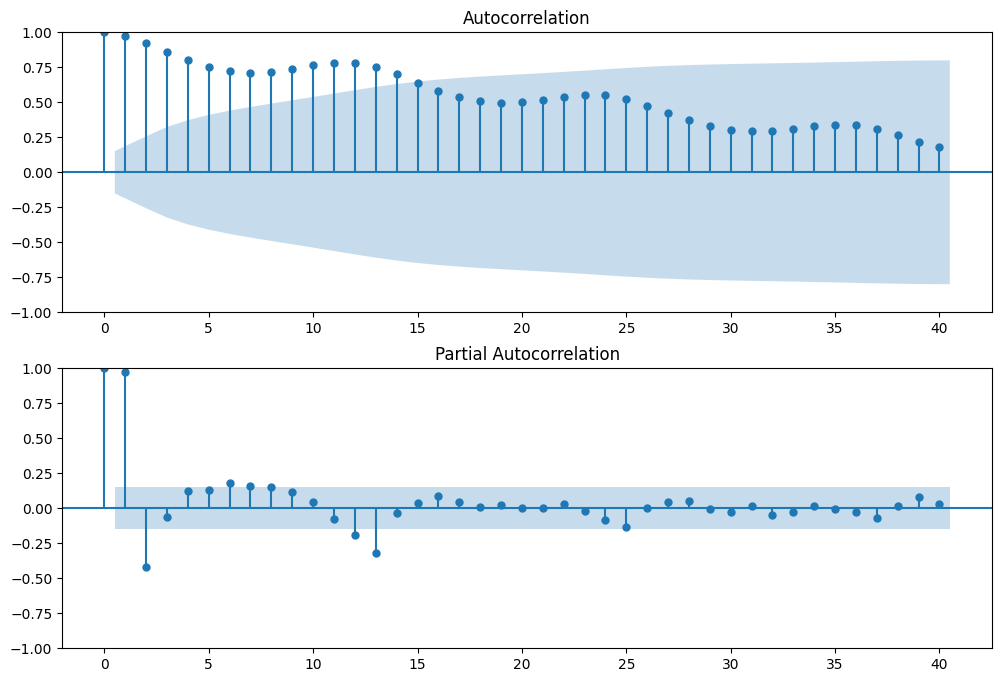

In [6]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Value'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Value'], lags=40, ax=ax2)

Checando si con una diferenciación ya es estacionaria...

In [7]:
df['diff_1'] = df['Value'].diff()

In [8]:
val_dickey_fuller = adfuller(df['diff_1'].dropna())
kpss_test = kpss(df['diff_1'].dropna())
print(f"Dickey-Fuller: {val_dickey_fuller[1]}")
print(f"KPSS: {kpss_test[1]}")

Dickey-Fuller: 0.02236230917339087
KPSS: 0.1


/tmp/ipykernel_13150/644339578.py:2: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Ya lo es!

En base a estas gráficas, parece que una configuración (2,1,2) podría ser un buen baseline.

In [9]:
arima_baseline_sm = ARIMA(df_train['Value'], order=(2,1,2)).fit()
print(arima_baseline_sm.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1393.332
Date:                Wed, 11 Feb 2026   AIC                           2796.663
Time:                        10:00:14   BIC                           2811.477
Sample:                             0   HQIC                          2802.683
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7338      0.007    251.263      0.000       1.720       1.747
ar.L2         -0.9974      0.007   -152.826      0.000      -1.010      -0.985
ma.L1         -1.7461      0.126    -13.834      0.0

/home/sofi/Documents/vscode/archivos_mnlpp/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Checando los residuales...

In [10]:
residuales = arima_baseline_sm.resid[1:]
fig = px.line(residuales, y=residuales)
fig.show()

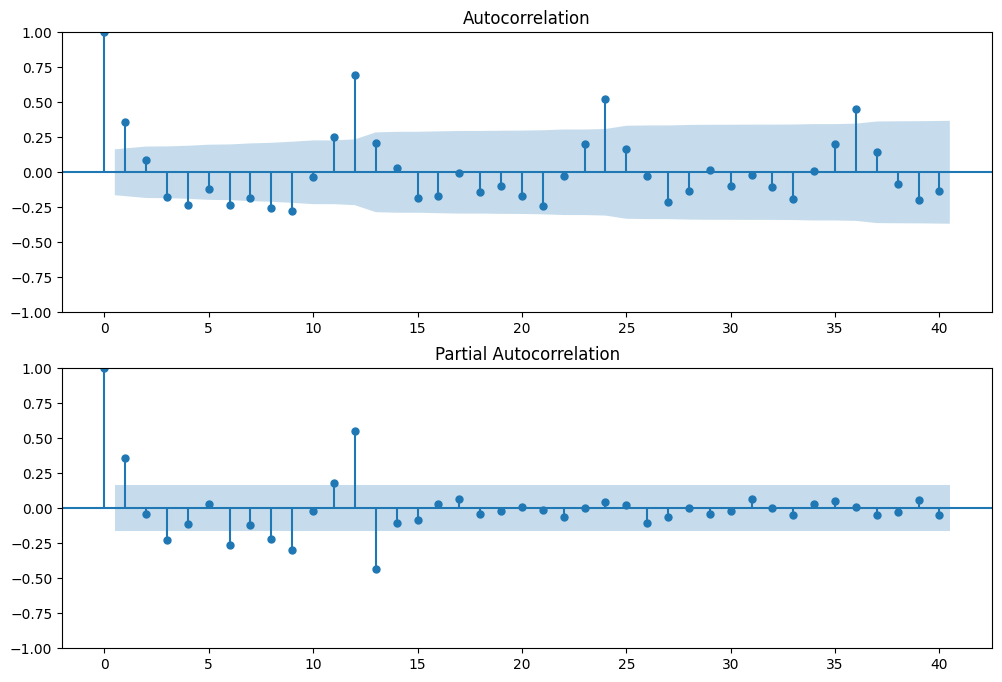

In [11]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuales, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuales, lags=40, ax=ax2)

Prediciendo...

<Axes: xlabel='Period'>

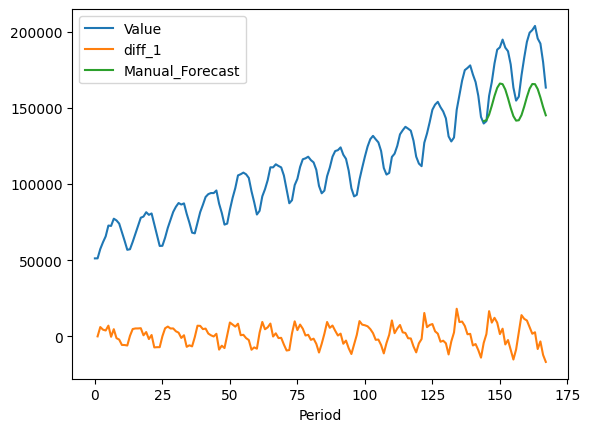

In [12]:
preds_sm = arima_baseline_sm.forecast(len(df_test)) # Es decir, para 2023 y 2024

df['Manual_Forecast'] = [None]*len(df_train) + list(preds_sm)

df.plot()

In [13]:
df_test.head()

,Period,Value
Period,,
144,Jan-2023,139736
145,Feb-2023,141283
146,Mar-2023,157866
147,Apr-2023,166932
148,May-2023,179139


In [14]:
len(df_test)

24

In [15]:
# Checando RMSE

scaler = StandardScaler()
scaled_test = scaler.fit_transform(df_test['Value'].values.reshape(-1,1))
scaled_preds = scaler.transform(preds_sm.values.reshape(-1,1))

rmse_sm = root_mean_squared_error(scaled_test, scaled_preds)
print(rmse_sm)

1.454818274099234


Ahora vamos a probar **StatsForecast**, con el mismo orden ya que funcionó bastante bien

In [16]:
arima_baseline_sf = sf.ARIMA(order=(2,1,2))

In [17]:
arima_baseline_sf.fit(df['Value'])

ARIMA

In [18]:
preds_sf = arima_baseline_sf.forecast(y=df_train['Value'], h=len(df_test))

In [19]:
preds_sf['mean']

array([134192.35515977, 127689.25815375, 126288.63325715, 126343.2175819 ,
       126475.35373341, 126515.57314691, 126518.43793193, 126516.14128033,
       126515.13267827, 126514.97828536, 126515.00798471, 126515.03055281,
       126515.03576804, 126515.03569842, 126515.03525156, 126515.03510622,
       126515.03509338, 126515.03510083, 126515.0351044 , 126515.035105  ,
       126515.03510491, 126515.03510483, 126515.03510481, 126515.03510481])

<Axes: xlabel='Period'>

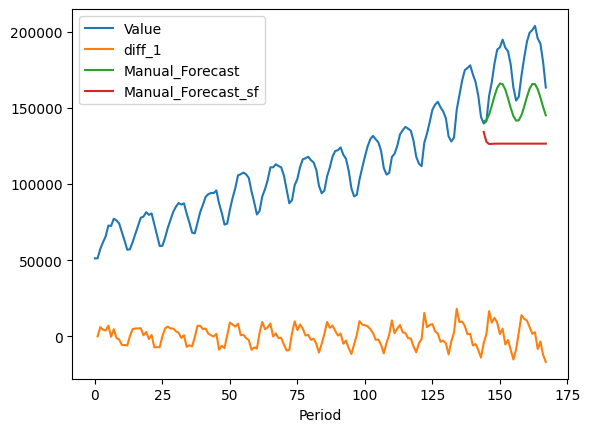

In [20]:
df['Manual_Forecast_sf'] = [None]*len(df_train) + list(preds_sf['mean'])

df.plot()

In [21]:
scaled_preds_sf = scaler.transform(preds_sf['mean'].reshape(-1,1))

rmse_sf = root_mean_squared_error(scaled_test, scaled_preds_sf)
print(rmse_sf)

2.996193424021641


Finalmente, se va a probar pmdarima para que busque el orden automáticamente

In [22]:
pmd_fit = auto_arima(y=df['Value'], start_p=1, start_q=1, max_p=5, max_q=5,d=1, seasonal=True)

/home/sofi/Documents/vscode/archivos_mnlpp/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/sofi/Documents/vscode/archivos_mnlpp/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/sofi/Documents/vscode/archivos_mnlpp/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/sofi/Documents/vscode/archivos_mnlpp/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/sofi/Documents/vscode/archivos_mnlpp/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'forc

In [23]:
print(pmd_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  168
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1674.161
Date:                Wed, 11 Feb 2026   AIC                           3352.322
Time:                        10:00:15   BIC                           3358.558
Sample:                             0   HQIC                          3354.853
                                - 168                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4961      0.019     25.592      0.000       0.458       0.534
sigma2      2.463e+07   1.47e-10   1.68e+17      0.000    2.46e+07    2.46e+07
Ljung-Box (L1) (Q):                   7.21   Jarque-

Parece que encontró el orden (1,1,0) como el mejor de todos

In [24]:
arima_best_sm = ARIMA(df_train['Value'], order=(1,1,0)).fit()
print(arima_best_sm.summary())

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  144
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1424.997
Date:                Wed, 11 Feb 2026   AIC                           2853.993
Time:                        10:00:15   BIC                           2859.919
Sample:                             0   HQIC                          2856.401
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4460      0.019     23.668      0.000       0.409       0.483
sigma2      2.103e+07   1.53e-10   1.37e+17      0.000     2.1e+07     2.1e+07
Ljung-Box (L1) (Q):                   7.67   Jarque-

<Axes: xlabel='Period'>

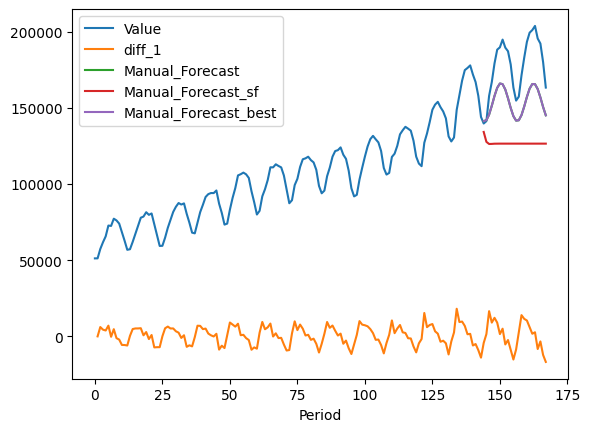

In [25]:
preds_best = arima_baseline_sm.forecast(len(df_test)) # Es decir, para 2023 y 2024

df['Manual_Forecast_best'] = [None]*len(df_train) + list(preds_best)

df.plot()

In [26]:
# Checando RMSE

scaled_preds_best = scaler.transform(preds_best.values.reshape(-1,1))

rmse_sm = root_mean_squared_error(scaled_test, scaled_preds_best)
print(rmse_sm)

1.454818274099234


### Conclusiones

StatsForecast fue la librería que peores resultados dió. Statsmodels es bastante mejor y pmdarima es un add-on muy bueno para StatsModels que facilita las búsquedas automáticas de parámetros para ARIMA.

Yo usaría StatsModels y pmdarima al mismo tiempo. PMDArima es útil para conseguir los valores directamente pero StatsModels es bastante más robusta para conseguir las gráficas ACF y PACF, hacer los resúmenes de los modelos, sacar predicciones y graficarlas. 